In [1]:
import numpy as np 
import pandas as pd 
import os 
import sys 
import plotly.graph_objects as go 
import re

import pyKVFinder

In [2]:
sys.path.append('/data/jlu/OR_learning/utils/')

import BindingCavity_functions as bc 
import voxel_functions as vf
import color_function as cf 


In [3]:
import importlib 

importlib.reload(bc)
importlib.reload(vf)

<module 'voxel_functions' from '/data/jlu/OR_learning/utils/voxel_functions.py'>

### Concept testing

In [21]:
# Define paths of AF files 
AF2_PATH = '/data/jlu/AF_files/AF_tmaligned_pdb'
pdb_files = os.listdir(AF2_PATH)


In [ ]:
# Simple workflow of using pyKVFinder and visualizing binding cavity
results = pyKVFinder.run_workflow(os.path.join(AF2_PATH, pdb_files[0]))

manual_color = cf.distinct_colors(np.unique(results.cavities))
manual_color[0] = '#D3D3D3' # Define protein space as grey 

fig = bc.single_Olfr_cavity(results.cavities, color_dict=manual_color)
fig.show()
fig.write_html('/data/jlu/OR_learning/output/binding_cavity/misc/TEST_Olfr_cav.html')

In [ ]:
"""
Conceptual pipeline for batch analysis. 

Utilizes pyKVFinder standard workflow 
- extract cavity grid 
- convert cavity grid to coordinates 
- super impose original pdb protein with cavity

"""


TEST_Olfr = ['Olfr224', 'Olfr330', 'Olfr1377']
TEST_Olfr = ['Olfr735', 'Olfr225', 'Olfr1377'] # Weird looking ones from PCA outlier 

# sulfur_Olfr = ['Olfr224', 'Olfr328', 'Olfr330', 'Olfr329'] # Sulfur responding Olfr

pdb_to_read = []
for _pdb in pdb_files: 
    if _pdb.split('_')[0] in TEST_Olfr: 
        pdb_to_read.append(_pdb)

# Running pyKVFinder standard workflow for cavity grid
bc_results = []
# bc_atomic = []

for _pdb in pdb_to_read: 
    bc_results.append(pyKVFinder.run_workflow(os.path.join(AF2_PATH, _pdb)))
    # bc_atomic.append(pyKVFinder.read_pdb(os.path.join(AF2_PATH, _pdb)))

# For testing the grid
# vertices = []
# for _atomic in bc_atomic: 
#     vertices.append(pyKVFinder.get_vertices(_atomic))

# Extracting cav coordinates from cavity grid 
bc_cav_coords = []
for _results in bc_results: 
    bc_cav_coords.append(bc.grid2coords(_results))
    
# Read in original pdb to visualize 
pdb_coords = []
for _pdb in pdb_to_read: 
    coords, backbone, _ = bc.load_pdb_coordinates(os.path.join(AF2_PATH, _pdb))
    pdb_coords.append([coords, backbone])


# Figure plotting
fig = go.Figure()

color_map = cf.distinct_colors(list(range(3)))

# Iterate and plot individual cavities
for i, _cv in enumerate(bc_cav_coords): 
    for _cv_x in _cv[0]: 
        fig.add_trace(go.Scatter3d(
            x=_cv[0][_cv_x].T[0],
            y=_cv[0][_cv_x].T[1],
            z=_cv[0][_cv_x].T[2],
            mode='markers',
            marker=dict(
                size=5,
                color=color_map[i],  # Color for this value
                opacity=0.2
            ),
            name=f"{pdb_to_read[i].split('.')[0]} cav",  # Add the value to the legend
            legendgroup=f"cavity_{i}",  # Group legend entries for this value
            showlegend=_cv_x == list(_cv[0].keys())[0]  # Only show legend for the first trace in this group
        ))

# Iterate and plot individual pdb coordinates
for i, _pdb in enumerate(pdb_coords): 
    fig.add_trace(go.Scatter3d(
        y=_pdb[1].T[0],
        x=_pdb[1].T[1],
        z=_pdb[1].T[2],
        mode='markers',
        marker=dict(
            size=7,
            color=color_map[i],  # Color for this value
            opacity=0.3
        ),
        name=f"{pdb_to_read[i].split('.')[0]} prot"  # Add the value to the legend
    ))
    
# Iterate and plot a single backbone to help visualization
fig.add_trace(go.Scatter3d(
    y=pdb_coords[0][1].T[0],
    x=pdb_coords[0][1].T[1],
    z=pdb_coords[0][1].T[2],
    mode='markers',
    marker=dict(
        size=7,
        color='#D3D3D3',  # Color for this value
        opacity=0.2
    ),
    name=f"{pdb_to_read[0].split('.')[0]} backbone"  # Add the value to the legend
))
    
fig.update_layout(
    scene=dict(
            xaxis=dict(visible=False, showbackground=False),
            yaxis=dict(visible=False, showbackground=False),
            zaxis=dict(visible=False, showbackground=False)
        ),
    margin=dict(r=10, l=10, b=10, t=10),
    legend_title="Values"
)

fig.show()
# fig.write_html('/data/jlu/OR_learning/output/binding_cavity/misc/TEST_cav_alignment.html')

### Make batch bc_cav file 
- dictionary form of binding cavity results is generated via OR_learning/scripts/bc_cavity_dump.py
- OR entries are kept in dictionary with DL nomenclature

In [ ]:
"""

FOR TESTING . . . DON'T RUN HERE. REFER TO scripts/bc_cavity_dump.py

"""
# from tqdm import tqdm

# Olfr_DL = pd.read_csv('../../files/Olfr_DL.csv', index_col=0)
# pdb_files = os.listdir(AF2_PATH)

# # Running pyKVFinder standard workflow for cavity grid
# bc_cav_coords = {}
# bc_results = []
# # bc_atomic = []
# for _pdb in tqdm(pdb_files): 
#     _olfr = _pdb.split('_')[0]
#     if _olfr in list(Olfr_DL.Olfr): 
#         bc_results = pyKVFinder.run_workflow(os.path.join(AF2_PATH, _pdb))
#         # bc_atomic.append(pyKVFinder.read_pdb(os.path.join(AF2_PATH, _pdb)))
        
#         # Store in dict with DL_OR name
#         bc_cav_coords[Olfr_DL[Olfr_DL.Olfr == _olfr].DL_OR.item()] = bc.grid2coords(bc_results)


### Loading data 

In [4]:
# # Re order and combine cavities for individual OR from pyKV result format 

# # Open pickle file of binding cavity dictionary
# import pickle 
# file = open('/data/jlu/OR_learning/files/dict_bc_pyKVcav_tmaligned.pkl', 'rb')
# # dump information to that file
# bc_pyKVcav_coords = pickle.load(file)
# file.close()


# # Convert from bc.grid2coords output format for each entry of coords, center, minmax to only coords
# # Additionally combines all cavity coords into a single array instead of separate key for individual cavity 
# bc_cav_coords = {}
# for key in bc_pyKVcav_coords:
#     combined_coords = []
#     for subkey in bc_pyKVcav_coords[key][0]:
#         combined_coords.extend(bc_pyKVcav_coords[key][0][subkey])
#     bc_cav_coords[key] = combined_coords
    
# # Re-order based on OR names
# bc_cav_coords = {i: bc_cav_coords[i] for i in np.sort(list(bc_cav_coords.keys()))}

# # Save dict as pkl 
# with open('/data/jlu/OR_learning/files/dict_bc_cav_tmaligned.pkl', 'wb') as f:
#     pickle.dump(bc_cav_coords, f)

In [4]:
# Open pickle file of binding cavity dictionary
import pickle 
file = open('/data/jlu/OR_learning/files/dict_bc_cav_tmaligned.pkl', 'rb')
# dump information to that file
bc_cav_coords = pickle.load(file)

In [5]:
# Create cavity voxels from coordinates 

# DROP Or defined in the exclusion list below
EXCLUDE_OR_LIST = ['Or4Q3', 'Or2W25', 'Or2l1', 'Or4A67', 'Or2I1']
bc_cav_coords = {key: value for key, value in bc_cav_coords.items() if key not in EXCLUDE_OR_LIST}
# DROP non DL_OR names
bc_cav_coords = {key: value for key, value in bc_cav_coords.items() if key.startswith('Or')}


# Voxelize binding cavity coordinates 
voxelized_cavities, voxel_shape = vf.voxelize_coordinates(list(bc_cav_coords.values()), resolution=1)

# Output: List of 1D arrays representing voxelized space
print(np.array(voxelized_cavities).shape)

(1080, 72, 81, 69)


In [6]:
Olfr_DL = pd.read_csv('../../files/Olfr_DL.csv', index_col=0)
# Olfr_DL.loc[Olfr_DL.Olfr.isin(['Olfr1377', 'Olfr224', 'Olfr330'])]
# Olfr_DL.loc[Olfr_DL.DL_OR.isin(['Or51E2', 'Or51E1'])]

### Testing cavity alignment via voxel transformation

In [ ]:
# TEST visualize binding cavity alignment in voxel form
"""
Testing workflow of 
- binding cavity coordinates > voxelized coordinate 
visualization to ensure the alignment is preserved 
"""

test = {key: value for key, value in bc_cav_coords.items() if key in ['Or1Ad1', 'Or2T43', 'Or2T48']}
voxelized_cavities, voxel_shape = vf.voxelize_coordinates(list(test.values()), resolution=0.6)

# Output: List of 1D arrays representing voxelized space
print(np.array(voxelized_cavities).shape)

voxel_data = voxelized_cavities
voxel_size = 1

Or_name = ['Or1Ad1', 'Or2T43', 'Or2T48']
# Create a plotly scatter plot
fig = go.Figure()

color_map = cf.distinct_colors(list(range(3)))
for i, voxel_grid in enumerate(voxel_data):
    # Get the coordinates of the occupied voxels (where voxel value is 1)
    occupied_voxels = np.array(np.where(voxel_grid == 1)).T
    
    # Convert the voxel indices back to 3D space coordinates
    x = occupied_voxels[:, 0] * voxel_size
    y = occupied_voxels[:, 1] * voxel_size
    z = occupied_voxels[:, 2] * voxel_size
    
    # Add the points to the plot
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        name=Or_name[i],
        marker=dict(size=3, 
                    color=color_map[i], 
                    opacity=0.3)
    ))

# Update layout for 3D visualization
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(r=10, l=10, b=10, t=10),
    title="Voxelized Binding Cavity in 3D"
)
fig.show()
# fig.write_html('../../output/binding_cavity/misc/TEST_bc_voxel_alignment.html')

### PCA cavity 
- quick PCA dimensional reduction to visualize distribution via cavity itself 

In [ ]:
from sklearn.decomposition import PCA

# Example: voxelized_cavities is a list of 3D binary arrays (0s and 1s)
# Flatten the voxelized cavities into a 2D array
flattened_voxelized_cavities = np.array([voxel.flatten() for voxel in voxelized_cavities])

# Center the data (subtract the mean of each feature)
mean_centered_data = flattened_voxelized_cavities - np.mean(flattened_voxelized_cavities, axis=0)

# Remove features (columns) with no variance (all 0s or all 1s)
non_constant_mask = np.std(mean_centered_data, axis=0) > 0
filtered_data = mean_centered_data[:, non_constant_mask]

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Reduce to 2 dimensions
reduced_data = pca.fit_transform(filtered_data)
variance_ratio = pca.explained_variance_ratio_

print("Reduced data shape:", reduced_data.shape)
print("Explained variance ratio:", variance_ratio)


pca_df = pd.DataFrame(reduced_data, columns=['PCA_1', 'PCA_2'],
                        index=list(bc_cav_coords.keys()))
pca_df.to_csv('../../output/binding_cavity/PCA/pca_df.csv')

Reduced data shape: (1080, 2)
Explained variance ratio: [0.05885063 0.04478302]


In [ ]:
# Visualize pca 
OR_name = list(bc_cav_coords.keys())

# Extract the Or_group using a list comprehension with regex
or_groups = [re.match(r'(Or\d+[A-Za-z])', str(name)).group(0) for name in OR_name if name.startswith('Or')]
or_groups_unique = list(set(or_groups))

# Assigns OR group color
color_map = cf.distinct_colors(or_groups_unique)
# Initialize a set to track displayed legend groups
shown_legend_groups = set()

fig = go.Figure()
for i, data in enumerate(reduced_data):
    if OR_name[i].startswith('Or'): 
        # Extracts the OR group 
        OR_group = re.match(r'(Or\d+[A-Za-z])', str(OR_name[i])).group(0)
        
        # Determine whether to show the legend for this group
        show_legend = OR_group not in shown_legend_groups
        if show_legend:
            shown_legend_groups.add(OR_group)
        fig.add_trace(go.Scatter(x = [data[0]],
                                y = [data[1]],
                                mode = 'markers', 
                                marker=dict(
                                    color = color_map[OR_group]
                                ),
                                name = f'{OR_group} family',
                                hovertext= OR_name[i],
                                legendgroup=OR_group,
                                showlegend=show_legend # Only show legend for the first trace in this group
            ))
    else: 
        fig.add_trace(go.Scatter(x = [data[0]],
                                y = [data[1]],
                                name = OR_name[i], 
                                mode = 'markers'))        
fig.update_traces( marker=dict(size=10, opacity = 0.5))
fig.update_layout(xaxis_title = f'PC1 ({variance_ratio[0]*100:.2f}%)',
                  yaxis_title = f'PC2 ({variance_ratio[1]*100:.2f}%)',
                  margin=dict(r=10, l=10, b=10, t=10),
                  plot_bgcolor='white',  # set the plot background color to white
                  paper_bgcolor='white',  # set the paper background color to white
)
fig.show()
# fig.write_html('../../output/binding_cavity/PCA/PCA_res1.html')

In [ ]:
# Visualize pca 
OR_name = list(bc_cav_coords.keys())

# Extract the Or_group using a list comprehension with regex
or_groups = [re.match(r'(Or\d+)', str(name)).group(0) for name in OR_name if name.startswith('Or')]
or_groups_unique = list(set(or_groups))

# Assigns OR group color
color_map = cf.distinct_colors(or_groups_unique)
# Initialize a set to track displayed legend groups
shown_legend_groups = set()

fig = go.Figure()
for i, data in enumerate(reduced_data):
    if OR_name[i].startswith('Or'): 
        # Extracts the OR group 
        OR_group = re.match(r'(Or\d+)', str(OR_name[i])).group(0)
        
        # Determine whether to show the legend for this group
        show_legend = OR_group not in shown_legend_groups
        if show_legend:
            shown_legend_groups.add(OR_group)
        fig.add_trace(go.Scatter(x = [data[0]],
                                y = [data[1]],
                                mode = 'markers', 
                                marker=dict(
                                    color = color_map[OR_group]
                                ),
                                name = f'{OR_group} family',
                                hovertext= OR_name[i],
                                legendgroup=OR_group,
                                showlegend=show_legend # Only show legend for the first trace in this group
            ))
    else: 
        fig.add_trace(go.Scatter(x = [data[0]],
                                y = [data[1]],
                                name = OR_name[i], 
                                mode = 'markers'))        
fig.update_traces( marker=dict(size=10, opacity = 0.5))
fig.update_layout(xaxis_title = f'PC1 ({variance_ratio[0]*100:.2f}%)',
                  yaxis_title = f'PC2 ({variance_ratio[1]*100:.2f}%)',
                  margin=dict(r=10, l=10, b=10, t=10),
                  plot_bgcolor='white',  # set the plot background color to white
                  paper_bgcolor='white',  # set the paper background color to white
)
fig.show()
# fig.write_html('../../output/binding_cavity/PCA/PCA_res1_ORfamily.html')

In [13]:
# TODO 
# Generate PCA pairwise euclidean distance 

pca_df = pd.read_csv('../../output/binding_cavity/PCA/pca_df.csv', index_col=0)

In [39]:
from scipy.spatial.distance import pdist, squareform

# Calculate pairwise Euclidean distances
distances = pdist(pca_df.values, metric="euclidean")


# converting distance to z-score 
mean_dist = np.mean(distances)
std_dist = np.std(distances)
z_scores = (distances - mean_dist) / std_dist

# Convert to a squareform distance matrix
distance_matrix = pd.DataFrame(
    squareform(distances), 
    index=pca_df.index, 
    columns=pca_df.index
)

# Extract the upper triangular part of the matrix (excluding the diagonal)
triu_indices = np.triu_indices_from(distance_matrix, k=1)
pairwise_distances = pd.DataFrame({
    "OR1": distance_matrix.index[triu_indices[0]],
    "OR2": distance_matrix.columns[triu_indices[1]],
    "Distance": distances, 
    "z-score": z_scores
})

In [46]:
corr_df = pd.read_csv('../../output/binding_cavity/Correlation/corr_df.csv', index_col=0)

In [ ]:

# Extract the upper triangular part of the matrix (excluding the diagonal)
triu_indices = np.triu_indices_from(corr_df, k=1)
pairwise_distances = pd.DataFrame({
    "OR1": distance_matrix.index[triu_indices[0]],
    "OR2": distance_matrix.columns[triu_indices[1]],     
    "Distance": distances, 
    "z-score": z_scores, 
    "bc_Correlation": np.array(corr_df)[triu_indices[0]]
})

In [66]:
z_scores

array([ 1.74443368,  1.57882601,  1.69692824, ..., -0.76748964,
       -0.60770823, -1.48243518], shape=(582660,))

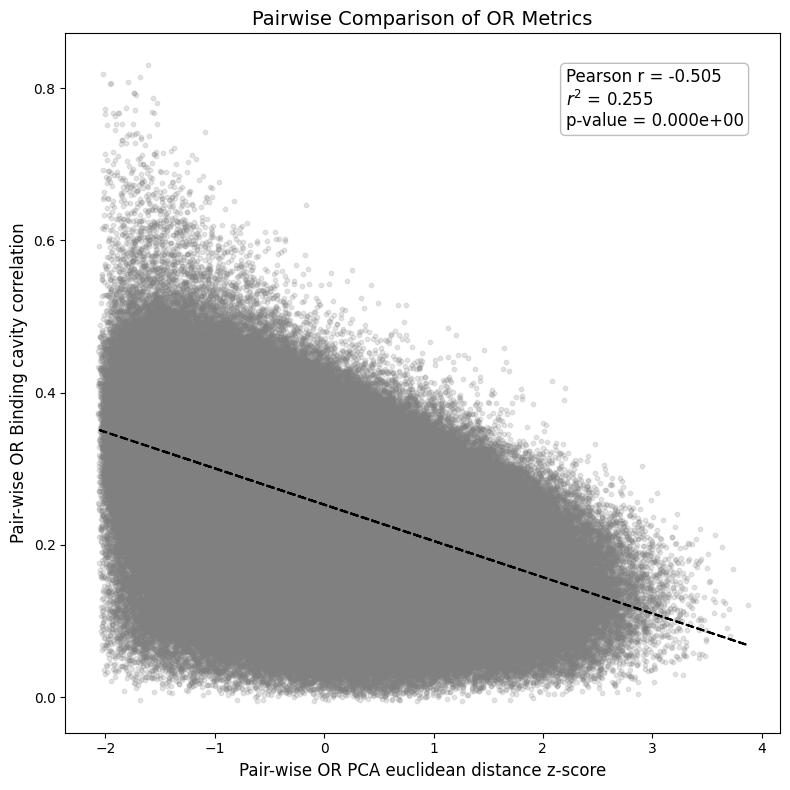

In [81]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# Get common sets of OR between pS6-IP and bc corr_df
shared_OR = list(set.intersection(set(corr_df.index), set(distance_matrix.index)))
distance_matrix = distance_matrix.loc[distance_matrix.index.isin(shared_OR)][np.sort(shared_OR)]

# Extract the upper triangular indices (excluding the diagonal)
triu_indices = np.triu_indices_from(np.array(distance_matrix), k=1)
values1 = np.array(z_scores)
# values1 = np.array(distance_matrix)[triu_indices]
values2 = np.array(corr_df)[triu_indices]

# Calculate Pearson correlation and p-value
r, p_value = pearsonr(values1, values2)
# Calculate the line of best fit
slope, intercept, _, _, _ = linregress(values1, values2)

# Create the scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(values1, values2, color='gray', alpha=0.2, s=10)
plt.plot(values1, slope * values1 + intercept, color="black", linestyle="--", label="Pearson Line")

# Add labels, title, and grid
plt.xlabel("Pair-wise OR PCA euclidean distance z-score", fontsize=12)
plt.ylabel("Pair-wise OR Binding cavity correlation", fontsize=12)
plt.title("Pairwise Comparison of OR Metrics", fontsize=14)

# Add text annotation for Pearson correlation, r^2, and p-value
plt.text(
    0.7, 0.95,  # Adjust position as needed
    f"Pearson r = {r:.3f}\n$r^2$ = {r**2:.3f}\np-value = {p_value:.3e}",
    fontsize=12,
    ha="left",va="top",
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.5),
)

# Show the plot
plt.tight_layout()
# plt.savefig(f'../../output/binding_cavity/Correlation/corr_scatter_PCAzscore.png')
plt.show()

### Jaccard pair-wise comparison 

In [ ]:
Olfr_DL = pd.read_csv('../../files/Olfr_DL.csv', index_col=0)
Olfr_DL.loc[Olfr_DL.DL_OR.isin(['Or51E2'])]

In [ ]:
# For TESTING ONLY 
"""
For the full implementation run via scripts/bc_jaccard.py
"""

from tqdm import tqdm
from sklearn.metrics import jaccard_score

# DROP Or defined in the exclusion list below
TEST_OR_LIST = ['Or1Ad1', 'Or2T43', 'Or2T48', 'Or10A2',]
TEST_bc_cav_coords = {key: bc_cav_coords[key] for key in TEST_OR_LIST}
# TEST_bc_cav_coords = {key: value for key, value in bc_cav_coords.items() if key in TEST_OR_LIST}

# Voxelize binding cavity coordinates 
TEST_voxelized_cavities, voxel_shape = vf.voxelize_coordinates(list(TEST_bc_cav_coords.values()), resolution=1)



# Example: voxelized_cavities is a list of 3D binary arrays (0s and 1s)
# Flatten each voxel array into a 1D array for pairwise comparison
flattened_voxels = [voxel.flatten() for voxel in TEST_voxelized_cavities]

# Initialize an empty matrix to store Jaccard similarity scores
num_voxels = len(flattened_voxels)
jaccard_matrix = np.zeros((num_voxels, num_voxels))

# Compute pairwise Jaccard index
for i in tqdm(range(num_voxels)):
    for j in range(i, num_voxels):  # Only compute upper triangle (matrix is symmetric)
        jaccard_index = jaccard_score(flattened_voxels[i], flattened_voxels[j])
        jaccard_matrix[i, j] = jaccard_index
        jaccard_matrix[j, i] = jaccard_index  # Symmetric entry

# Print the resulting pairwise Jaccard matrix
print("Pairwise Jaccard Similarity Matrix:")
print(jaccard_matrix)

In [ ]:
fig = go.Figure(data=go.Heatmap(
    x = TEST_OR_LIST,
    y = TEST_OR_LIST,  
    z=jaccard_matrix, 
    text=np.round(jaccard_matrix,3), 
    texttemplate="%{text}",
    textfont={"size":20},
    colorscale='viridis'))
fig.show()
# fig.write_html('/data/jlu/OR_learning/output/binding_cavity/Jaccard/TEST_jaccard_matrix.html')

### Correlation matrix 

In [43]:
# DROP Or defined in the exclusion list below
TEST_OR_LIST = ['Or1Ad1', 'Or2T43', 'Or2T48', 'Or10A2',]
TEST_bc_cav_coords = {key: bc_cav_coords[key] for key in TEST_OR_LIST}

# Voxelize binding cavity coordinates 
TEST_voxelized_cavities, voxel_shape = vf.voxelize_coordinates(list(TEST_bc_cav_coords.values()), resolution=1)

flattened_voxels = [voxel.flatten() for voxel in TEST_voxelized_cavities]

TEST_corr_matrix = np.corrcoef(flattened_voxels)

fig = go.Figure(data=go.Heatmap(
    x = TEST_OR_LIST,
    y = TEST_OR_LIST,  
    z=TEST_corr_matrix, 
    text=np.round(TEST_corr_matrix,3), 
    texttemplate="%{text}",
    textfont={"size":20},
    colorscale='viridis'))
fig.show()
# fig.write_html('/data/jlu/OR_learning/output/binding_cavity/Correlation/TEST_corr_matrix.html')

In [ ]:
# Save corr_matrix for downstream comparison 
flattened_voxels = [voxel.flatten() for voxel in voxelized_cavities]

corr_matrix = np.corrcoef(flattened_voxels)
corr_df = pd.DataFrame(corr_matrix, 
             columns=bc_cav_coords.keys(), 
             index=bc_cav_coords.keys())
# corr_df.to_csv('/data/jlu/OR_learning/output/binding_cavity/Correlation/corr_df.csv', index=0)

In [ ]:

# Quick peak of df
filter_OR = ['Or1A1', 'Or2T43', 'Or2T48', 'Or51E1']
corr_df.loc[(corr_df.index.isin(filter_OR))][filter_OR]

### pS6-IP metric

In [153]:
# Load in pS6-IP df 
pS6_df = pd.read_csv('../../files/pS6IP_MASTER_HL_Annotated_2024.csv')

# Create a metric for pS6 
pS6_df['logFC_adj'] = pS6_df['logFC'] * -np.log10(pS6_df['FDR'])
pS6_df['FDR_-log10'] = -np.log10(pS6_df['FDR'])

In [ ]:
# Quick visualization of the distribution
pS6_df[['DL_OR', 'odor', 'logFC_adj', 'logFC', 'FDR', 'FDR_-log10']].plot(kind='scatter', x='logFC', y='FDR_-log10')

In [321]:
# Decide which metric to use 
METRIC_OF_RESPONSE = 'logFC_adj'
# METRIC_OF_RESPONSE = 'logFC'

# Creates table for running correlation on ps6
df = pS6_df[['DL_OR', 'odor_and_conc', METRIC_OF_RESPONSE]].pivot(index='DL_OR', columns='odor_and_conc', values=METRIC_OF_RESPONSE)

# Identify rows with all-zero responses. Zero response with 0 std across ligand creates issue when running corrcoef 
mask = ~(df.iloc[:, 1:] == 0).all(axis=1)
# Filter out rows with all-zero responses
df = df[mask]

# Removes odor (columns) with no response (0 std)
mask = df.values.std(axis=0) != 0
df = df[df.columns[mask]]

pS6_corr_df = pd.DataFrame(np.corrcoef(df), 
                           columns=df.index, 
                           index=df.index)
# pS6_corr_df.to_csv('../../output/binding_cavity/Correlation/pS6_corr_df')

In [322]:
# Get common sets of OR between pS6-IP and bc corr_df
shared_OR = list(set.intersection(set(corr_df.index), set(pS6_corr_df.index)))

# Subset pS6_corr_df by the ORs in cavity_correlation matrix 
pS6_corr_df = pS6_corr_df.loc[pS6_corr_df.index.isin(shared_OR)][np.sort(shared_OR)]
pS6_corr_df.head()

# For trouble shooting
# pS6_long = pd.DataFrame(pS6_corr_df.stack(), columns=['pS6_logFC_adj']).reset_index(names=['OR_x', 'OR_y'])
# pS6_long = pS6_long[pS6_long['OR_x'] != pS6_long['OR_y']]

DL_OR,Or10A2,Or10A3,Or10A3B,Or10A3M,Or10A3N,Or10A4,Or10A48,Or10A49,Or10A5,Or10Aa1,...,Or9Q1,Or9Q2,Or9R3,Or9R7,Or9S13,Or9S14,Or9S15,Or9S18,Or9S23,Or9S27
DL_OR,,,,,,,,,,,,,,,,,,,,,
Or10A2,1.000000,0.520720,0.708777,0.499738,0.084975,0.545075,0.023209,0.092020,0.598800,0.450189,...,0.049510,0.043412,0.521076,0.424729,0.263234,-0.120208,0.014570,0.462203,0.171885,0.489336
Or10A3,0.520720,1.000000,0.778034,0.236861,0.080805,0.140458,0.066214,0.125910,0.848191,0.124834,...,0.009521,-0.000283,0.934686,0.744869,0.560912,-0.036826,0.040329,0.104567,0.024957,0.116996
Or10A3B,0.708777,0.778034,1.000000,0.672619,0.052430,0.723888,0.069220,0.139525,0.852108,0.586207,...,0.070097,0.065210,0.739172,0.573052,0.420340,-0.195008,0.048155,0.594770,0.246106,0.624355
Or10A3M,0.499738,0.236861,0.672619,1.000000,0.053799,0.795268,0.003891,0.159609,0.457679,0.734365,...,0.095430,0.088083,0.243078,-0.008768,0.153624,-0.104933,0.058577,0.671576,0.254332,0.714618
Or10A3N,0.084975,0.080805,0.052430,0.053799,1.000000,0.028117,-0.570492,0.086143,0.168105,0.089932,...,0.009211,0.010979,0.221362,0.341668,-0.243832,0.209819,-0.200010,-0.008725,0.273268,0.096822


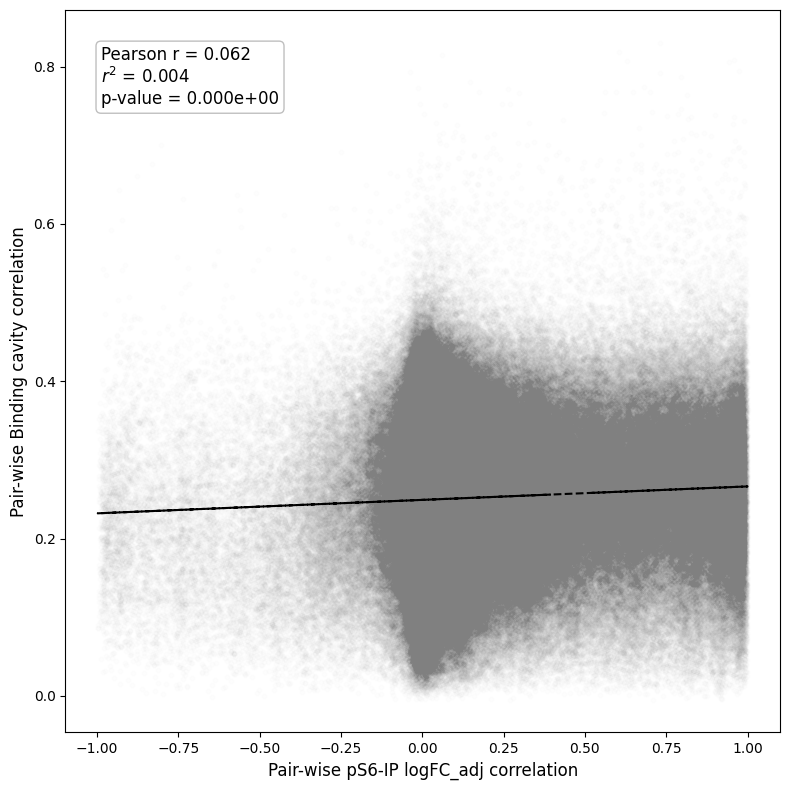

In [323]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# Extract the upper triangular indices (excluding the diagonal)
triu_indices = np.triu_indices_from(np.array(pS6_corr_df), k=1)

# Extract the corresponding values from both matrices
values1 = np.array(pS6_corr_df)[triu_indices]
values2 = np.array(corr_df)[triu_indices]

# Calculate Pearson correlation and p-value
r, p_value = pearsonr(values1, values2)
# Calculate the line of best fit
slope, intercept, _, _, _ = linregress(values1, values2)

# Create the scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(values1, values2, color='gray', alpha=0.01, s=10)
plt.plot(values1, slope * values1 + intercept, color="black", linestyle="--", label="Pearson Line")

# Add labels, title, and grid
plt.xlabel(f"Pair-wise pS6-IP {METRIC_OF_RESPONSE} correlation", fontsize=12)
plt.ylabel("Pair-wise Binding cavity correlation", fontsize=12)
# plt.title(f"Pairwise Comparison of OR", fontsize=14)

# Add text annotation for Pearson correlation, r^2, and p-value
plt.text(
    0.05, 0.95,  # Adjust position as needed
    f"Pearson r = {r:.3f}\n$r^2$ = {r**2:.3f}\np-value = {p_value:.3e}",
    fontsize=12,
    ha="left",va="top",
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.5),
)

# Show the plot
plt.tight_layout()
plt.savefig(f'../../output/binding_cavity/Correlation/corr_scatter_cav_{METRIC_OF_RESPONSE}.png')
plt.show()

#### Testing with 'Odor response' that's defined by Aashu. 
- https://github.com/avihani/Deorphanization/blob/main/4_Compile_descriptors_and_responses.ipynb
- https://www.biorxiv.org/content/10.1101/2021.12.27.474279v1.full.pdf

In [304]:

odor_sigResp = pd.read_csv('../../files/Deorphanization/compiled_odor_sigResp_wide.csv', index_col=0).T

# Translate Olfr to DL_OR 
odor_sigResp = pd.merge(odor_sigResp.reset_index(), Olfr_DL[['Olfr', 'DL_OR']], 
         left_on='index', right_on='Olfr', how='left')\
             .drop(['index', 'Olfr'], axis=1)\
                 .set_index('DL_OR')

In [310]:
# Calculate correlation in odor response
odorResp_corr_df = pd.DataFrame(np.corrcoef(odor_sigResp), 
                           columns=odor_sigResp.index, 
                           index=odor_sigResp.index)
# pS6_corr_df.to_csv('../../output/binding_cavity/Correlation/odorResp_corr_df', index=0)

In [ ]:
# Get common sets of OR between pS6-IP and bc corr_df
shared_OR = list(set.intersection(set(corr_df.index), set(odorResp_corr_df.index)))

# Subset pS6_corr_df by the ORs in cavity_correlation matrix 
odorResp_corr_df = odorResp_corr_df.loc[odorResp_corr_df.index.isin(shared_OR)][np.sort(shared_OR)]
odorResp_corr_df.head()


DL_OR,Or10A2,Or10A3,Or10A3B,Or10A5,Or10Ad1,Or10Ad1B,Or10Ag2,Or10Ag52,Or10Ag53,Or10Ag54,...,Or9G4B,Or9G8,Or9I1B,Or9M1B,Or9Q1,Or9Q2,Or9R3,Or9R7,Or9S13,Or9S15
DL_OR,,,,,,,,,,,,,,,,,,,,,
Or1E16,0.085398,0.085313,0.073770,0.075762,0.166241,0.220430,0.112344,0.259442,0.004782,0.087745,...,0.487468,0.138246,0.225685,0.389257,0.162931,0.163131,0.092095,0.245487,0.160258,0.154408
Or5G9,0.389727,0.699181,0.598600,0.465999,-0.011424,0.184414,0.118850,0.534147,0.588637,0.447398,...,0.144116,0.191811,0.282115,0.227256,0.334871,0.254423,0.536075,0.522442,0.409031,0.345742
Or9G3,-0.058987,0.177391,0.101401,0.253624,0.020479,0.111469,0.213428,0.145590,0.096862,-0.039698,...,0.513927,0.393077,-0.049539,0.284402,0.185761,0.180840,0.064263,0.158731,0.208401,0.166912
Or9G19,-0.147437,0.134161,0.131159,0.162751,-0.044266,0.022071,0.126205,0.115669,0.006467,-0.041646,...,0.507811,0.458703,-0.226308,0.101246,0.251875,0.158155,0.199520,0.092086,0.052681,0.013830
Or9G8,-0.009432,0.281244,0.212224,0.164961,0.316664,0.083302,0.250321,0.096043,0.191432,0.102200,...,0.422334,1.000000,-0.017803,0.065792,0.303449,0.180834,0.316319,-0.016784,0.332067,0.222386


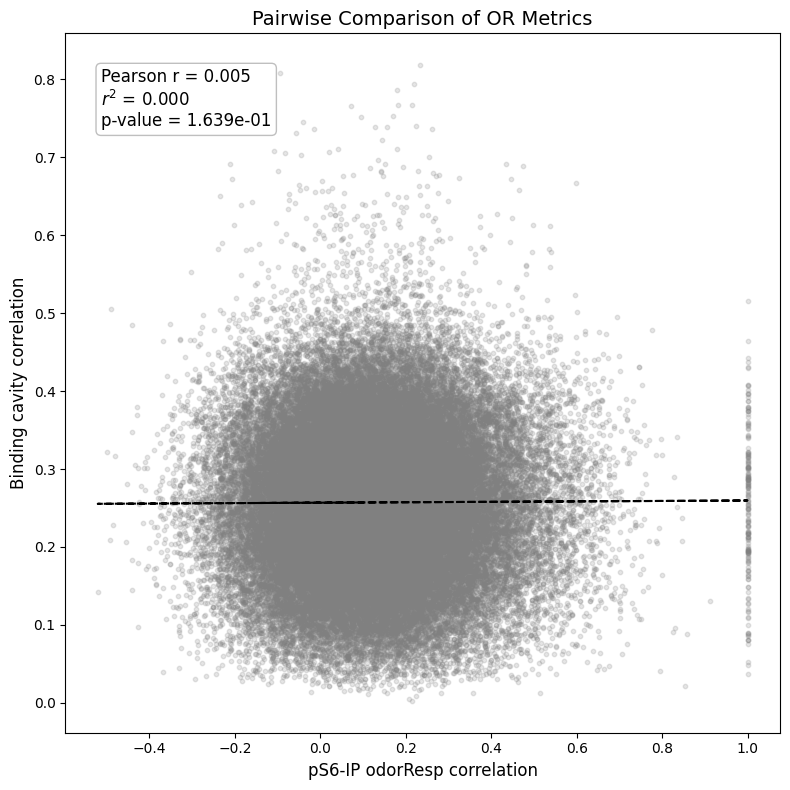

In [349]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# Extract the upper triangular indices (excluding the diagonal)
triu_indices = np.triu_indices_from(np.array(odorResp_corr_df), k=1)

# Extract the corresponding values from both matrices
values1 = np.array(odorResp_corr_df)[triu_indices]
values2 = np.array(corr_df)[triu_indices]

# Calculate Pearson correlation and p-value
r, p_value = pearsonr(values1, values2)
# Calculate the line of best fit
slope, intercept, _, _, _ = linregress(values1, values2)

# Create the scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(values1, values2, color='gray', alpha=0.2, s=10)
plt.plot(values1, slope * values1 + intercept, color="black", linestyle="--", label="Pearson Line")

# Add labels, title, and grid
plt.xlabel("pS6-IP odorResp correlation", fontsize=12)
plt.ylabel("Binding cavity correlation", fontsize=12)
plt.title("Pairwise Comparison of OR Metrics", fontsize=14)

# Add text annotation for Pearson correlation, r^2, and p-value
plt.text(
    0.05, 0.95,  # Adjust position as needed
    f"Pearson r = {r:.3f}\n$r^2$ = {r**2:.3f}\np-value = {p_value:.3e}",
    fontsize=12,
    ha="left",va="top",
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.5),
)

# Show the plot
plt.tight_layout()
plt.savefig(f'../../output/binding_cavity/Correlation/corr_scatter_cav_odorResp.png')
plt.show()

### Sequence Similarity Correlation

In [343]:
# Read in sequence similarity score table 
seq_long = pd.read_csv('../../../OR_learning/output/Olfr_sequence_similarity.csv', index_col=0)

# Create DL_OR mapping 
Olfr_DL = pd.read_csv('../../files/Olfr_DL.csv', index_col=0)
mapping_dict = dict(zip(Olfr_DL["Olfr"], Olfr_DL["DL_OR"]))

# Replace OR1 and OR2 Olfr values using the mapping dictionary
seq_long["OR1"] = seq_long["OR1"].replace(mapping_dict)
seq_long["OR2"] = seq_long["OR2"].replace(mapping_dict)


# Create a pivot table
seq_df = seq_long.pivot(index="OR1", columns="OR2", values="SeqScore")

# Ensure symmetry by combining the matrix with its transpose
seq_df = seq_df.combine_first(seq_df.T)

# Fill diagonal with 1
np.fill_diagonal(seq_df.values, 1)

seq_df.head()

,4930516K23Rik,Olfr1141,Olfr1433,Olfr1564,Olfr179,Olfr192,Olfr197,Olfr207,Olfr209,Olfr242,...,Or9Q1,Or9Q2,Or9R3,Or9R7,Or9S13,Or9S14,Or9S15,Or9S18,Or9S23,Or9S27
4930516K23Rik,1.000000,0.543233,0.573308,0.552632,0.535714,0.575188,0.577068,0.584586,0.584586,0.569549,...,0.562030,0.563910,0.563910,0.563910,0.524436,0.541353,0.541353,0.569549,0.535714,0.535714
Olfr1141,0.543233,1.000000,0.631579,0.567669,0.554511,0.644737,0.648496,0.644737,0.646617,0.622180,...,0.646617,0.640977,0.631579,0.637218,0.614662,0.622180,0.625940,0.665414,0.616541,0.624060
Olfr1433,0.573308,0.631579,1.000000,0.605263,0.609023,0.639098,0.644737,0.650376,0.648496,0.654135,...,0.676692,0.665414,0.652256,0.656015,0.624060,0.633459,0.642857,0.691729,0.640977,0.644737
Olfr1564,0.552632,0.567669,0.605263,1.000000,0.588346,0.590226,0.593985,0.588346,0.588346,0.593985,...,0.612782,0.622180,0.592105,0.599624,0.577068,0.584586,0.592105,0.622180,0.584586,0.595865
Olfr179,0.535714,0.554511,0.609023,0.588346,1.000000,0.586466,0.565789,0.599624,0.599624,0.578947,...,0.607143,0.612782,0.601504,0.605263,0.597744,0.590226,0.597744,0.605263,0.584586,0.601504


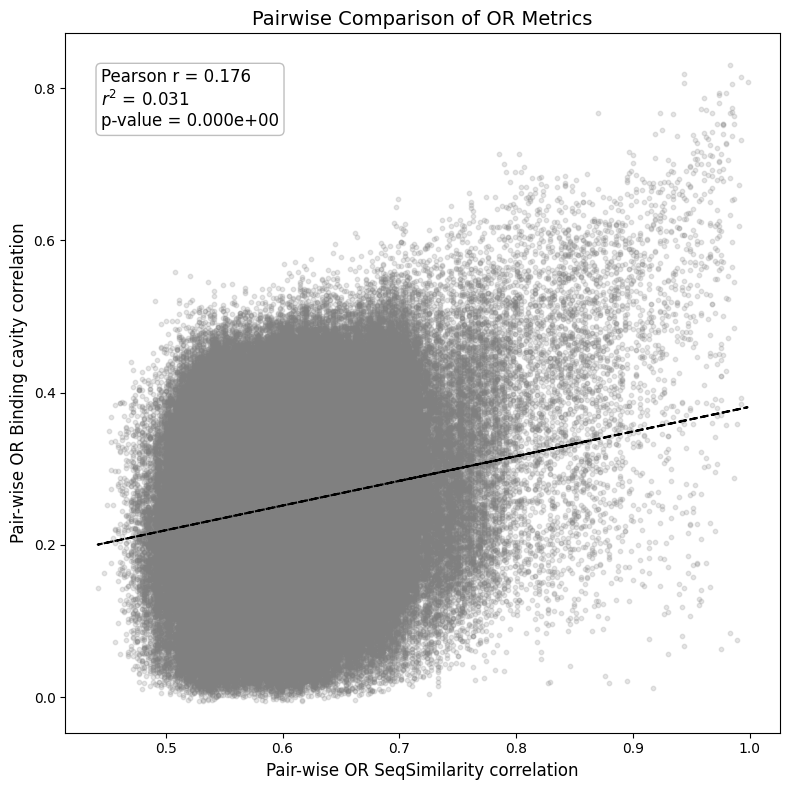

In [348]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# Get common sets of OR between pS6-IP and bc corr_df
shared_OR = list(set.intersection(set(corr_df.index), set(seq_df.index)))
seq_df = seq_df.loc[seq_df.index.isin(shared_OR)][np.sort(shared_OR)]

# Extract the upper triangular indices (excluding the diagonal)
triu_indices = np.triu_indices_from(np.array(seq_df), k=1)

# Extract the corresponding values from both matrices
values1 = np.array(seq_df)[triu_indices]
values2 = np.array(corr_df)[triu_indices]

# Calculate Pearson correlation and p-value
r, p_value = pearsonr(values1, values2)
# Calculate the line of best fit
slope, intercept, _, _, _ = linregress(values1, values2)

# Create the scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(values1, values2, color='gray', alpha=0.2, s=10)
plt.plot(values1, slope * values1 + intercept, color="black", linestyle="--", label="Pearson Line")

# Add labels, title, and grid
plt.xlabel("Pair-wise OR SeqSimilarity correlation", fontsize=12)
plt.ylabel("Pair-wise OR Binding cavity correlation", fontsize=12)
plt.title("Pairwise Comparison of OR Metrics", fontsize=14)

# Add text annotation for Pearson correlation, r^2, and p-value
plt.text(
    0.05, 0.95,  # Adjust position as needed
    f"Pearson r = {r:.3f}\n$r^2$ = {r**2:.3f}\np-value = {p_value:.3e}",
    fontsize=12,
    ha="left",va="top",
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.5),
)

# Show the plot
plt.tight_layout()
plt.savefig(f'../../output/binding_cavity/Correlation/corr_scatter_cav_seqSimilarity.png')
plt.show()

### NEXT TO DO 
- Find a metric for comparing binding cavities between Olfr
- Comapre binding cavities similarity with pS6-IP response 
- Find a metric for overall pS6-IP score ?
    - Perhaps dimensional reduction of pS6 table. can get pairwise euclidean distance when comparing A vs B Olfr 
    - Multiple score for pS6 (Overall Odor response rate, broadly/narrowly tuned . . . etc)
- Given A and B Olfr, how are the overall pS6-IP odor response correlate with cavitiy similarity ? 

### . . . 